In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import bayesflow as bf

In [3]:
np.set_printoptions(suppress=True)
RNG = np.random.default_rng(7373)

Goal is to simulate gaze position $(x, y)$ based upon angular position $\theta$, then see how posterior predicts.

In [6]:
# Read in the dataset
dataset = pd.read_csv('../../data/full_data2.csv', delimiter=";", usecols=['Gaze.x.', 'Gaze.y.', 'Subject', 'Ang_Pos', 'Lap_Number'])
dataset.shape

(194758, 5)

### The simulator

\begin{align}
    \sigma_x &\sim \mathrm{Gamma}(2, 2), \\
    \sigma_y &\sim \mathrm{Gamma}(0.5, 5), \\
    \alpha_x, \alpha_y &\sim \mathcal{N}(0, 5), \\
    \beta_x, \beta_y &\sim \mathcal{N}(0, 10), \\
    \tau &\sim \mathrm{Cauchy(0, 5)}, \\
    u_j &\sim \mathcal{N}(0, \tau), &\text{for }j=1, ..., J, \\
    \mathbf{x}_{nj} &\sim \mathcal{N}(\alpha_{\mathbf{x}} + u_j + \beta_{\mathbf{x}}\theta_m, \sigma_{\mathbf{x}}), \quad \mathbf{x}_n = (x_n, y_n) &\text{for }j=1, ..., J.
\end{align}

In [5]:
# Simulating just so this is not stupid.
N_OBS = 1000
angular_pos = RNG.gamma(0.5, 1., size=N_OBS)

In [12]:
PARAMS = [
    r'$\alpha_x$', 
    r'$\beta_x$', 
    r'$\sigma_x$', 
    r'$\alpha_y$',
    r'$\beta_y$', 
    r'$\sigma_y$',
    r'$\theta$'
]

In [7]:
def prior_fun(rng=None):

    if rng is None:
        rng = np.random.default_rng()

    alpha_x = rng.normal(0, 5)
    alpha_y = rng.normal(0, 5)
    beta_x = rng.normal(0, 10)
    beta_y = rng.normal(0, 10)
    sigma_x = rng.gamma(2, 2)
    sigma_y = rng.gamma(0.5, 5)
    angular_pos = RNG.gamma(0.5, 1.)

    theta = np.array([alpha_x, alpha_y, beta_x, beta_y, sigma_x, sigma_y, angular_pos])
    return theta

In [8]:
def simulator_fun(theta, n_obs=1000, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    alpha_x, alpha_y, beta_x, beta_y, sigma_x, sigma_y, angular_pos = theta

    x = RNG.normal(alpha_x + beta_x * angular_pos, sigma_x, size=n_obs)
    y = RNG.normal(alpha_y + beta_y * angular_pos, sigma_y, size=n_obs)

    return np.array([x, y])

In [9]:
theta = prior_fun(rng=RNG)
gaze_pos = simulator_fun(theta, rng=RNG)
gaze_pos.shape

(2, 1000)

<Axes: >

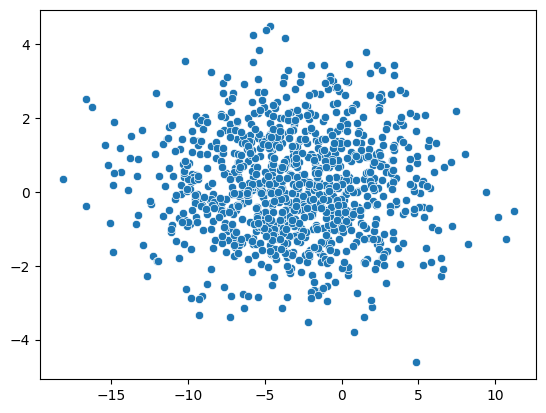

In [10]:
sns.scatterplot(x=gaze_pos[0], y=gaze_pos[1])

In [13]:
prior = bf.simulation.Prior(prior_fun=prior_fun, param_names=PARAMS)

### Prior predictive check

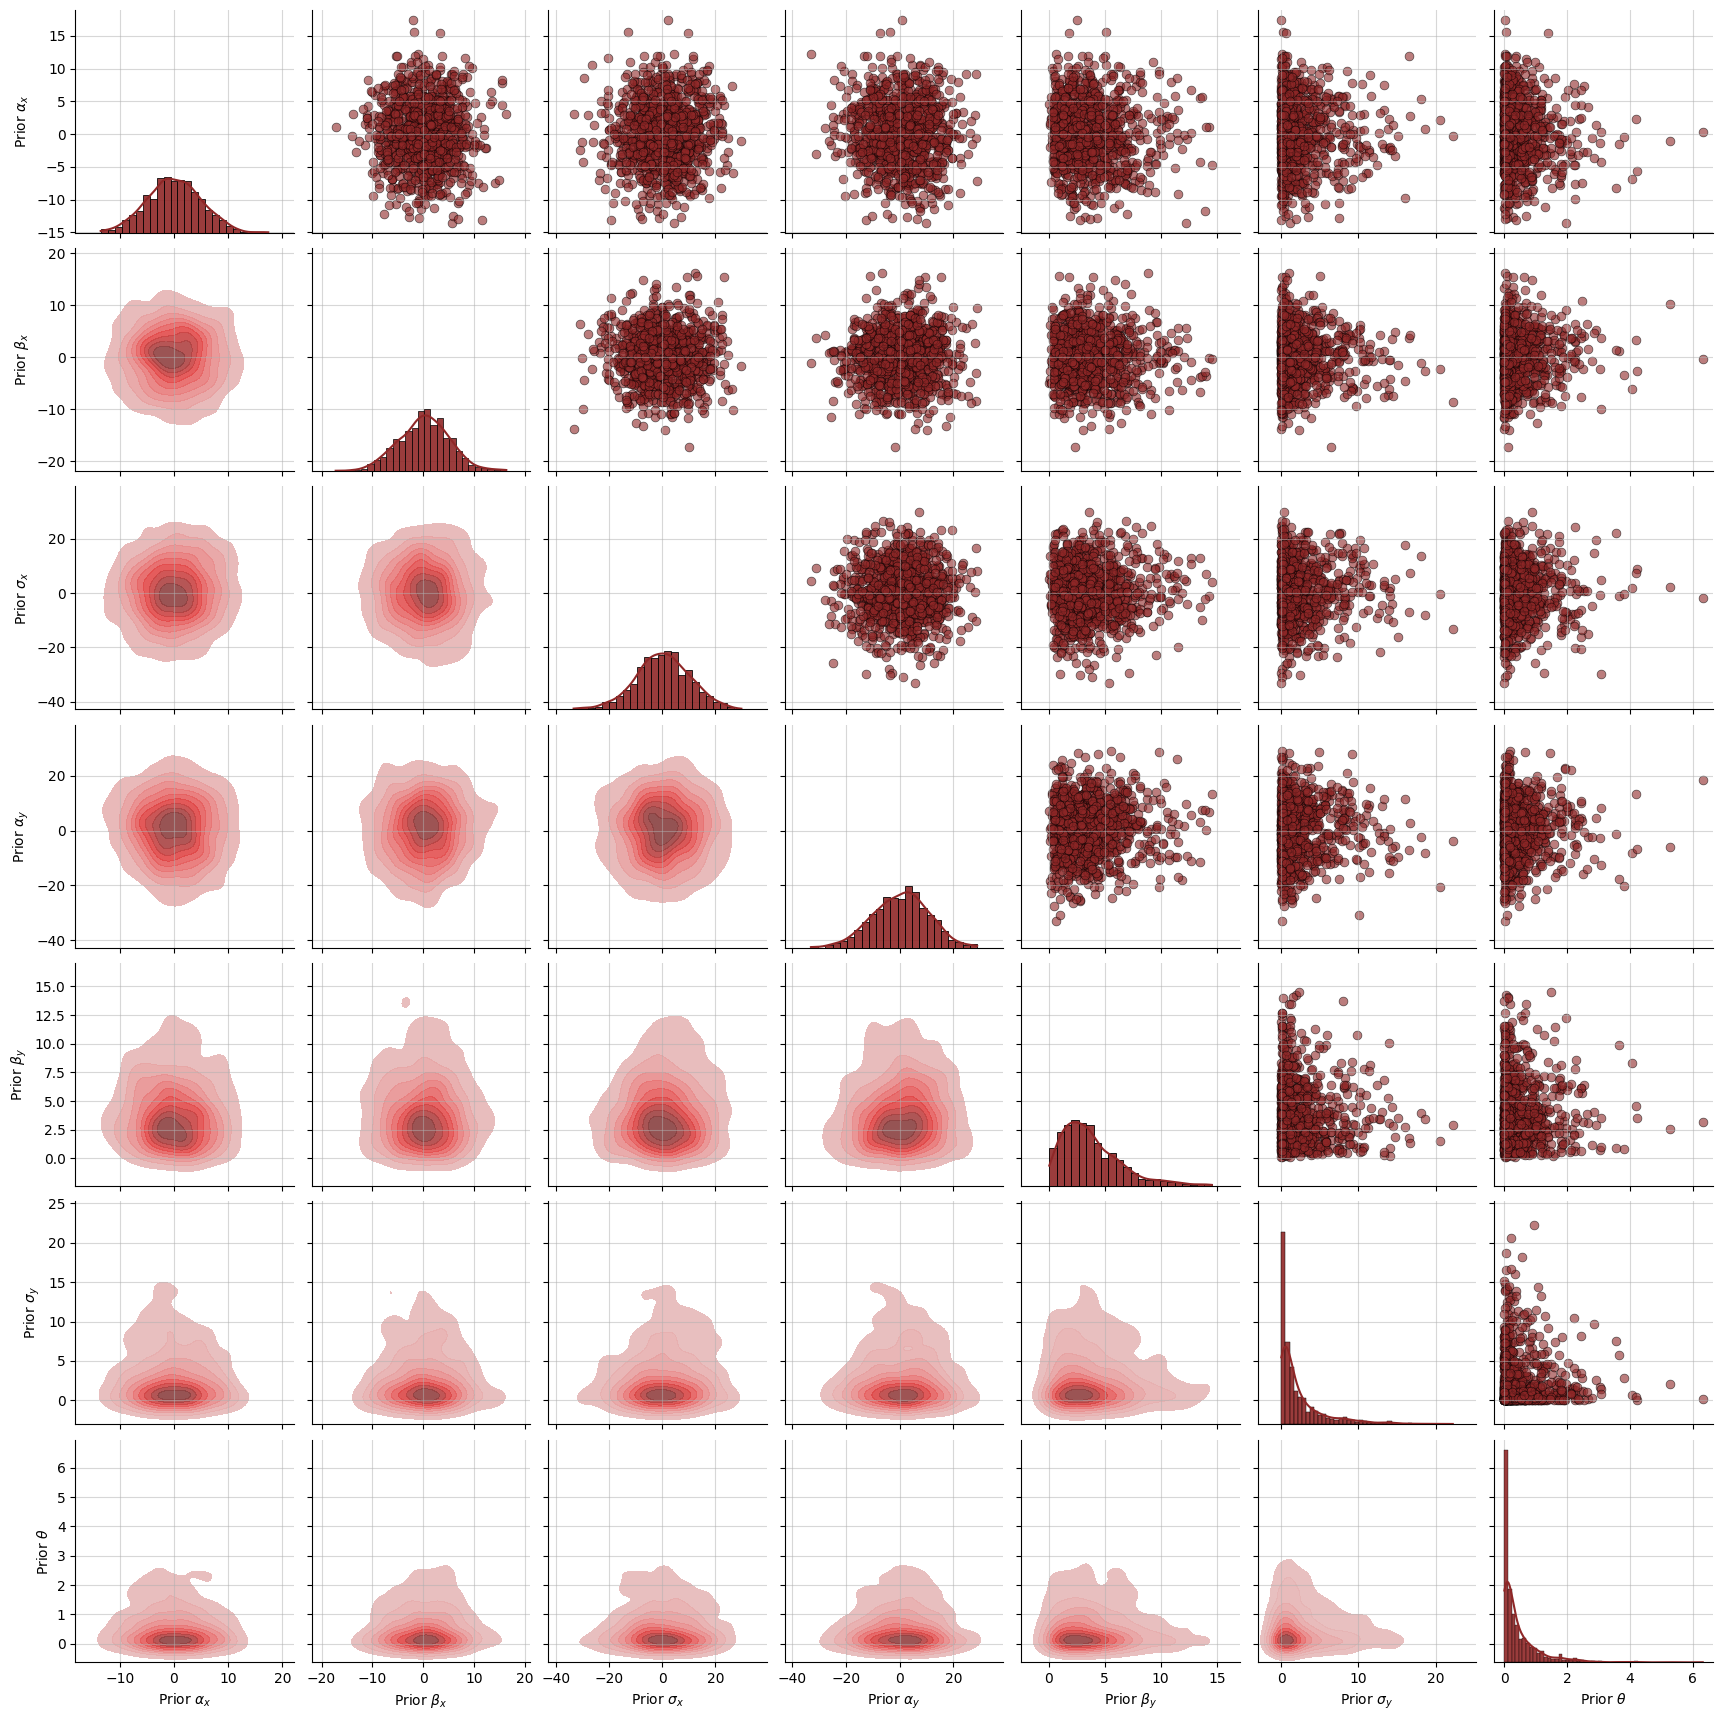

In [14]:
f = bf.simulation.plot_prior2d(prior=prior, n_samples=1000, param_names=PARAMS)

In [15]:
model = bf.simulation.GenerativeModel(
    prior=prior,
    simulator=simulator_fun,
    name="gaze",
    simulator_is_batched=False
)

INFO:root:Performing 2 pilot runs with the gaze model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2, 1000)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [16]:
sim = model(100)
sim['sim_data'].shape

(100, 2, 1000)

### Neural approximator

In [18]:
summary_net = bf.summary_networks.DeepSet()

In [19]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=len(PARAMS),
    num_coupling_layers=6,
    coupling_settings={
        "dense_args": dict(kernel_regularizer=None), 
        "dropout": True
    }
)

In [20]:
amortizer = bf.amortizers.AmortizedPosterior(
    inference_net=inference_net,
    summary_net=summary_net
)

In [21]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [22]:
amortizer.summary()

Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  451836    
 ibleNetwork)                                                    
                                                                 
 deep_set_1 (DeepSet)        multiple                  195210    
                                                                 
Total params: 647046 (2.47 MB)
Trainable params: 646962 (2.47 MB)
Non-trainable params: 84 (336.00 Byte)
_________________________________________________________________


In [23]:
history = trainer.train_online(epochs=30, iterations_per_epoch=200, batch_size=32)

Training epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/200 [00:00<?, ?it/s]

### Convergence

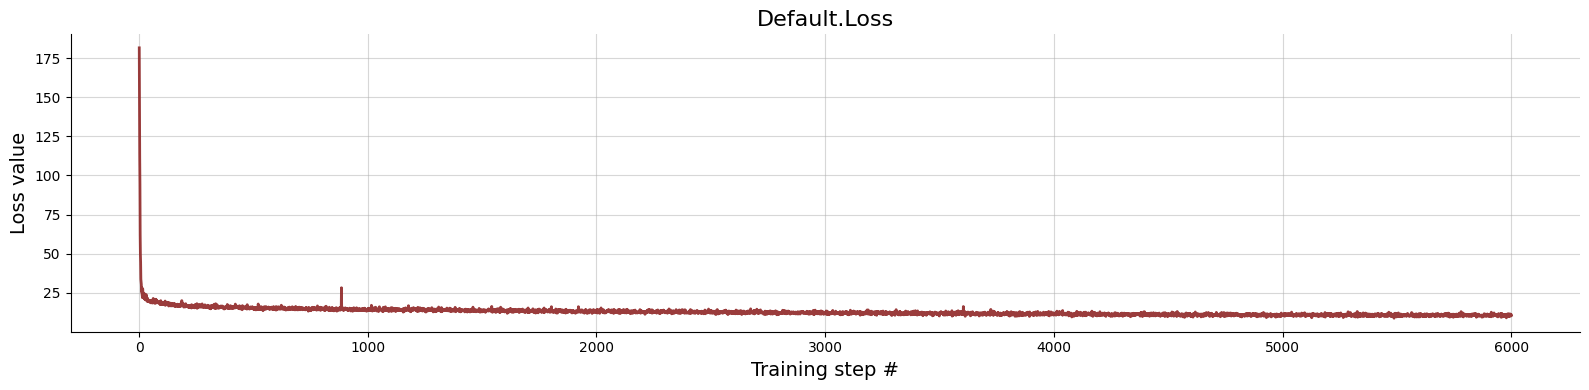

In [24]:
f = bf.diagnostics.plot_losses(history)

### Resimulation

<Axes: >

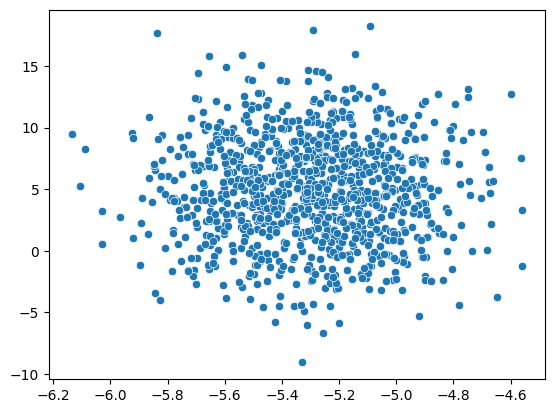

In [25]:
resim = trainer.configurator(model(500))
resim['summary_conditions'].shape
s = resim['summary_conditions'][0]
sns.scatterplot(x=s[0], y=s[1])

In [26]:
post_samples = amortizer.sample(resim, n_samples=1000)
post_samples.shape

(500, 1000, 7)

### Parameter recovery

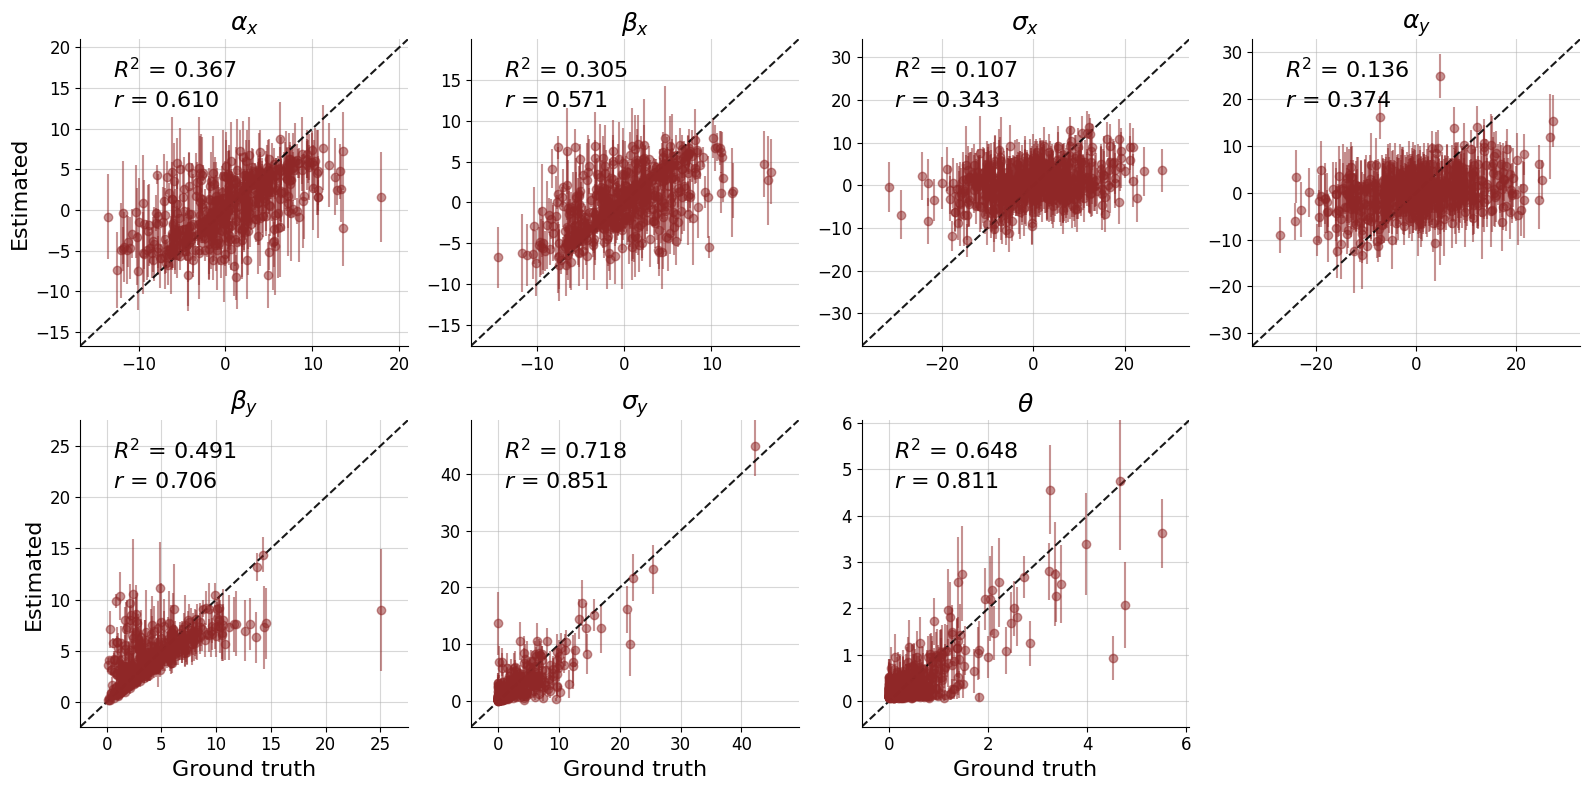

In [27]:
f = bf.diagnostics.plot_recovery(post_samples, resim['parameters'], param_names=PARAMS)

### Posterior Predictive Check

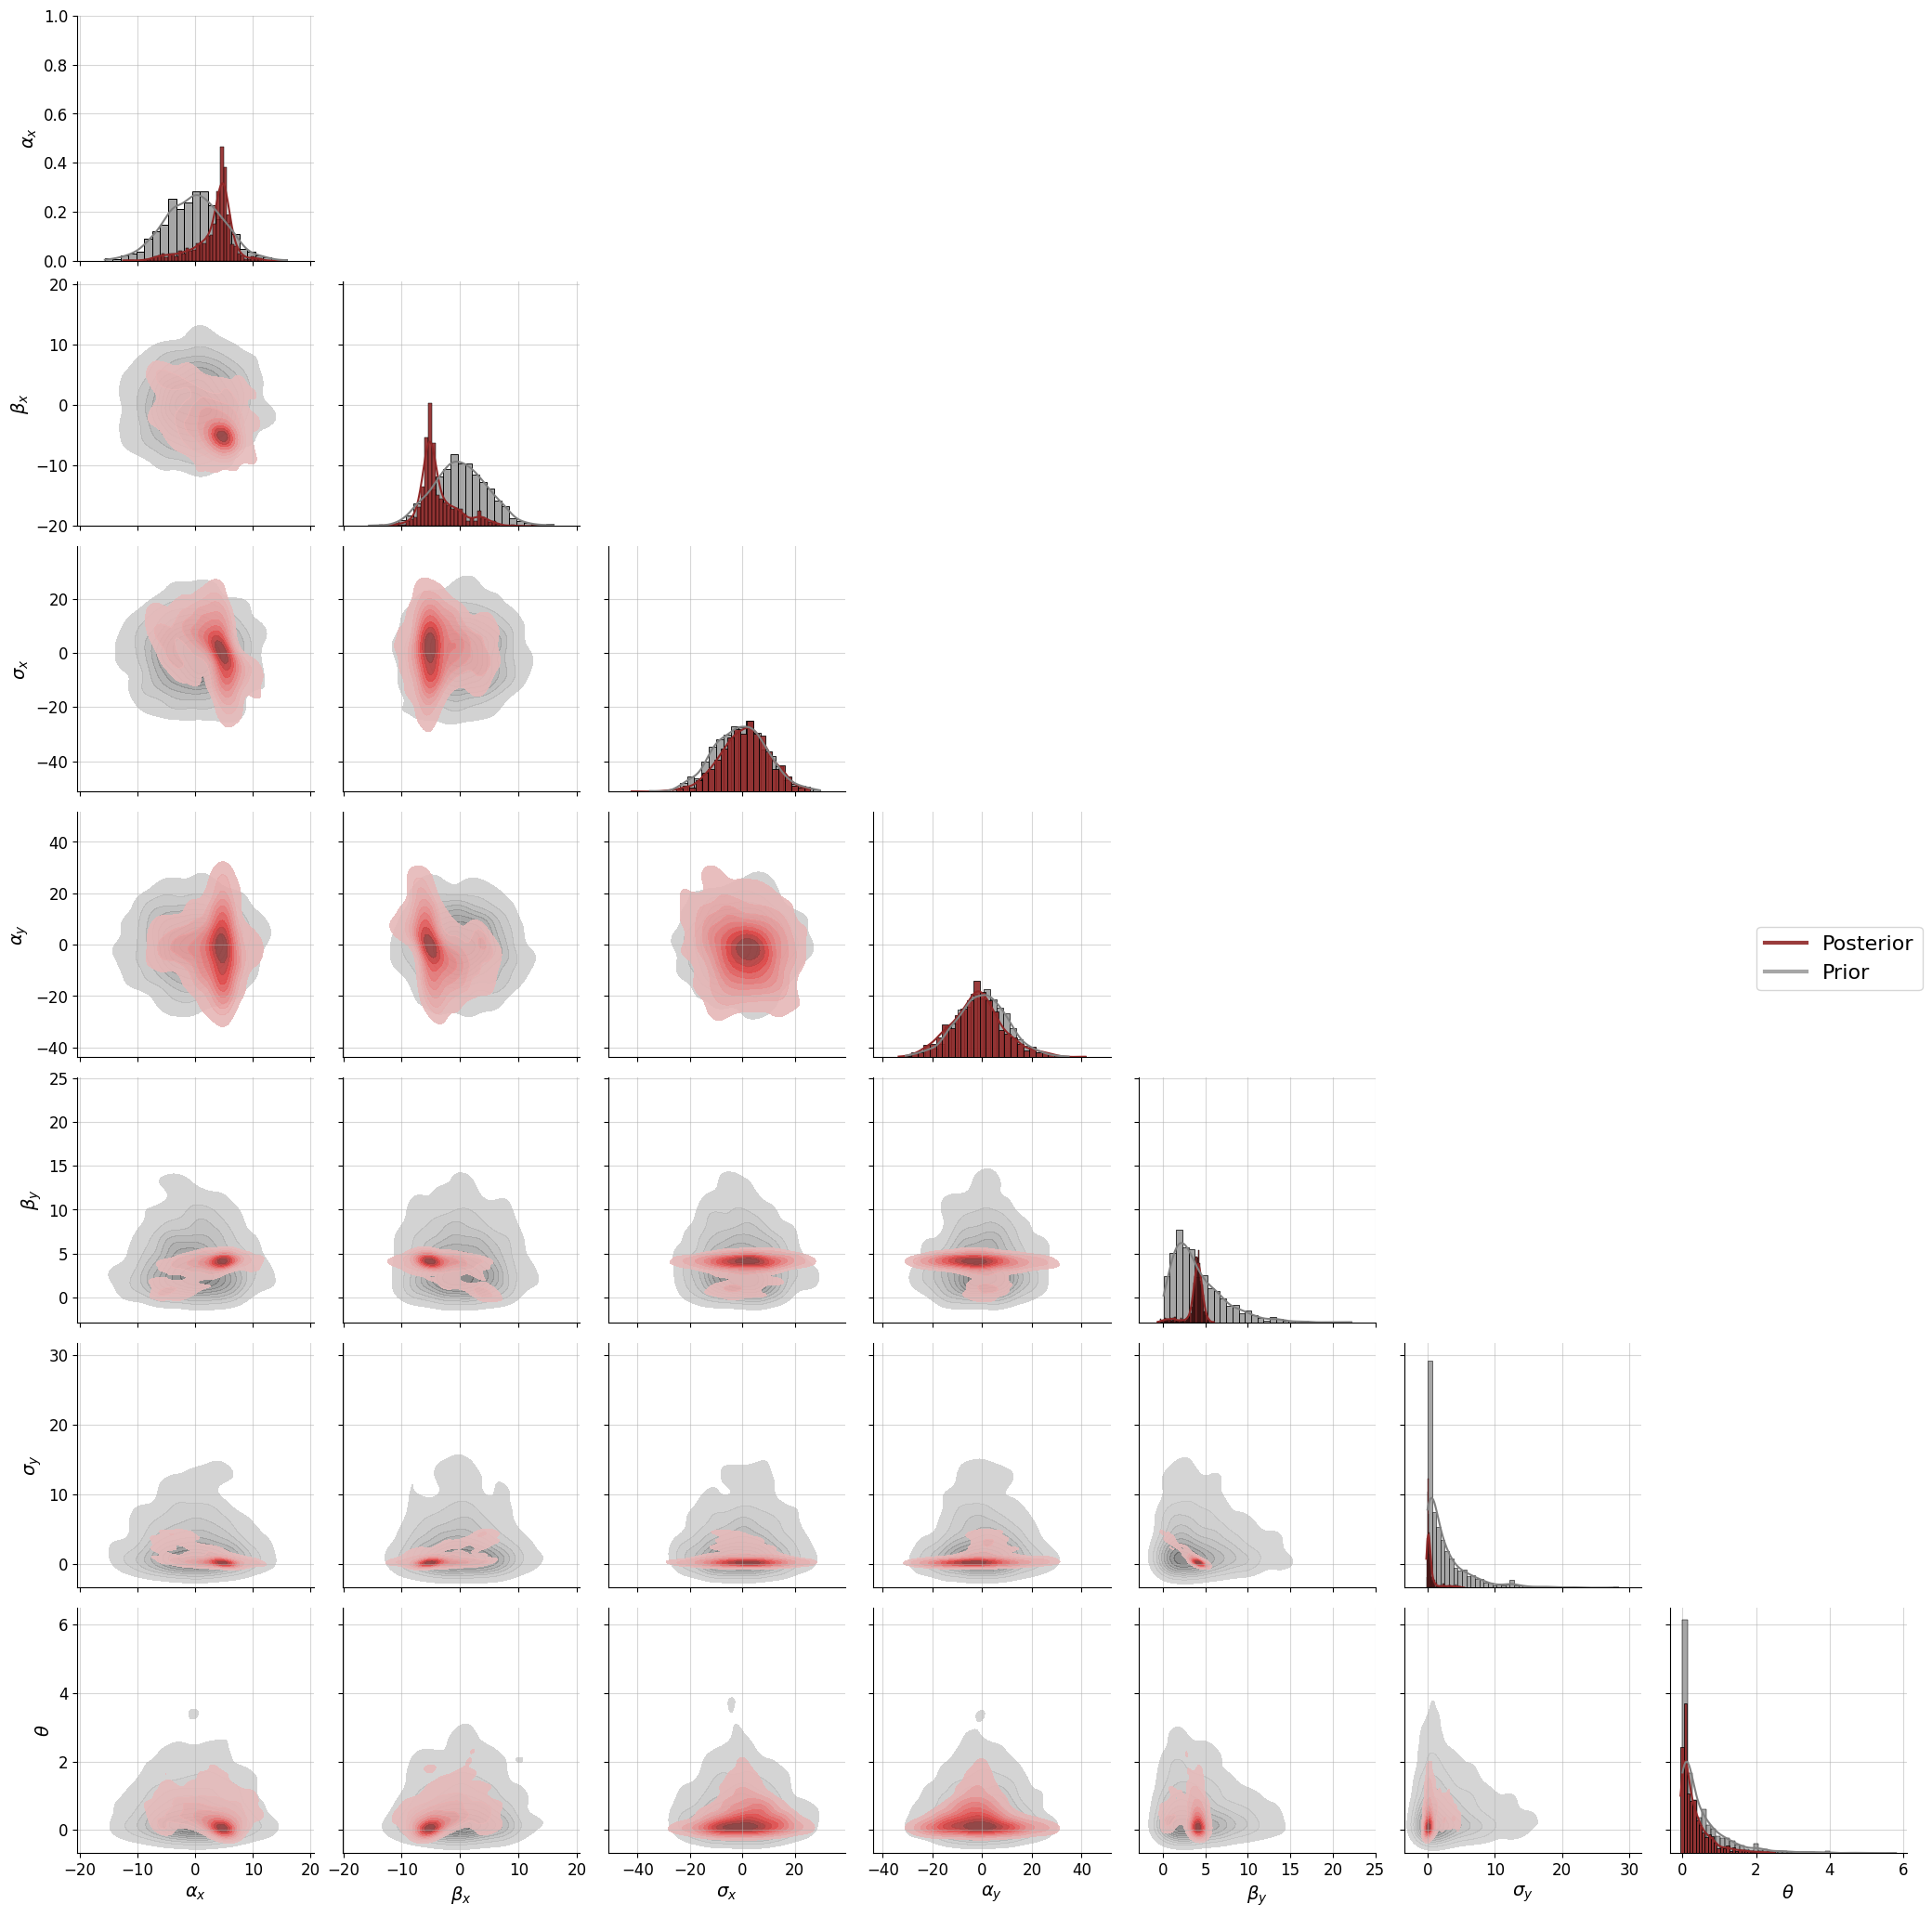

In [28]:
f = bf.diagnostics.plot_posterior_2d(post_samples[0], prior=prior)

not everything is learned super well (subject to prior sensitivity)